In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sys
!pip install impyute
from impyute.imputation.cs import mice
import seaborn as sns
from scipy.stats import pearsonr

Mounted at /content/drive


In [3]:
df=pd.read_csv('original_data.csv')

In [4]:
print(df.head())

      userName  ... admit
0       143saf  ...     1
1   7790ashish  ...     1
2         AB25  ...     1
3     abhijitg  ...     1
4  abhijitgang  ...     1

[5 rows x 26 columns]


**Cleaning the dataset**

In [5]:
def cleaning_phase(df):
  research_exp=df.researchExp
  industry_exp=df.industryExp
  intern_exp=df.internExp

  #filling 0 in place of null values if present in experience features
  df[['researchExp','industryExp','internExp']].fillna(value=0,inplace=True)

  #rescaling the experience features to a scale of 0-5
  def convert_range(old_min,old_max,new_min,new_max,data):
    for i in range(len(data)):
      new_value = (((data[i] - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min
      data[i]=new_value

  convert_range(research_exp.min(),research_exp.max(),0,5,research_exp)
  convert_range(intern_exp.min(),intern_exp.max(),0,5,intern_exp)
  convert_range(industry_exp.min(),industry_exp.max(),0,5,industry_exp)

  #check for null values in publications
  print(sum(df.journalPubs.isnull()),sum(df.confPubs.isnull()))
  
  #links present in journalPubs and datapoints in confPubs arent of right type and converting some rows which have digits stored as strings
  for index in range(len(df.journalPubs)):
    if type(df.journalPubs[index])==str and df.journalPubs[index].isdigit():
      df.journalPubs[index]=int(df.journalPubs[index])

  for index in range(len(df.confPubs)):
      if type(df.confPubs[index])==str and df.confPubs[index].isdigit():
        df.confPubs[index]=int(df.confPubs[index])
  
  df[df['journalPubs']=='http://www.edulix.com/unisearch/user.php?uid=225747']=np.nan
  
  df[df['confPubs']=='Fall - 2015']=np.nan
  df[df['confPubs']=='Fall - 2012']=np.nan
  df[df['confPubs']=='Fall - 2014']=np.nan

  #filling 0 in place of null values if present in publications features
  df[['journalPubs','confPubs']].fillna(value=0,inplace=True)

  #cleaning and transforming scores
  sys.setrecursionlimit(100000)
  df.drop(["gmatA","gmatQ","gmatV"],axis=1,inplace=True)
  imputed_training=mice(df[["greQ","greV","greA"]].values)
  imputedDf=pd.DataFrame()
  imputedDf[["greQ","greV","greA"]]=pd.DataFrame(imputed_training)
  imputedDf=imputedDf[["greQ","greV","greA"]]
  imputedDf.loc[:,"greQ"]=(imputedDf.loc[:,"greQ"]//10)*10
  imputedDf.loc[:,"greV"]=(imputedDf.loc[:,"greV"]//10)*10
  conversion=pd.read_csv("score.csv")
  conversion=pd.DataFrame(conversion)
  dQscores=dict()
  dVscores=dict()
  oldgreScores=conversion.iloc[:,0]
  newgreQScores=conversion.iloc[:,1]
  newgreVScores=conversion.iloc[:,2]
  def getDict(d,x,y):
      d[x]=y
      return d
  dQscores=list(map(lambda x,y:getDict(dQscores,x,y),oldgreScores,newgreQScores))[0]

  dVscores=list(map(lambda x,y:getDict(dVscores,x,y),oldgreScores,newgreVScores))[0]
  dScores=dict()
  for key in dQscores.keys():
      dScores[key]=(dQscores[key],dVscores[key])
  newQScores=[]
  newVScores=[]
  for i in range(len(imputedDf["greQ"])):
      if imputedDf["greQ"][i] > 800:
          newQScores.append(dScores[800][0])
      elif 170<imputedDf["greQ"][i]<200:
            newQScores.append(dScores[200][0])
      elif dScores.get(imputedDf["greQ"][i])==None:
          newQScores.append(int(imputedDf["greQ"][i]))
      else:
          newQScores.append(dScores.get(imputedDf["greQ"][i])[0])
  for i in range(len(imputedDf["greV"])):
      if imputedDf["greV"][i] > 800:
          newVScores.append(dScores[800][0])
      elif 170<imputedDf["greV"][i]<200:
            newVScores.append(dScores[200][0])
      elif dScores.get(imputedDf["greV"][i])==None:
          newVScores.append(int(imputedDf["greV"][i]))
      else:
          newVScores.append(dScores.get(imputedDf["greV"][i])[0])
  
  df["greQ"]=newQScores
  df["greV"]=newVScores
  cgpadf=df[["topperCgpa","cgpaScale"]].replace({0:np.nan})
  percentile=df["cgpa"]/df["topperCgpa"]
  df["Percentile"]=percentile*10
  df["Percentile"].fillna(0,inplace = True)

  df.loc[df["greA"] > 6,"greA"]=df['greA'].mean()
  df.loc[df["greV"] > 170,"greV"]=df['greV'].mean()
  df.loc[df["greQ"] > 170,"greQ"]=df['greQ'].mean()
  df.loc[df["Percentile"] > 10,"Percentile"]=10

  #Casting "toeflEssay" values to type Float
  df["toeflEssay"] = pd.to_numeric(df["toeflEssay"])
  df["toeflEssay"].fillna(df["toeflEssay"].mean(),inplace=True)

  df["toeflScore"].fillna(df["toeflScore"].median(),inplace=True)

  #Cleaning the department feature
  df.drop(df.loc[df['department']=='0'].index, inplace = True)

  #Cleaning the termAndYear feature
  df.drop(df.loc[df['termAndYear']==np.nan].index, inplace = True)
    
  #Cleaning the ugCollege feature
  df.drop(df.loc[df['ugCollege'].isnull()].index, inplace = True)

  dfAdmits=df[df["admit"]==1]
  dfAdmitsIndex=dfAdmits["univName"].value_counts().index.tolist()
  dfAdmitCounts=list()
  for i in dfAdmits["univName"].value_counts():
    dfAdmitCounts.append(i)

  return df


In [6]:
df = cleaning_phase(df)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



322 322


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Analyzing data using varieties of plots**

In [7]:
#to check if any of the columns are related if so what is the functional form
fig = px.scatter_matrix(df,dimensions=["internExp","industryExp","researchExp","Percentile","greA","greV","greQ"])
fig.show()

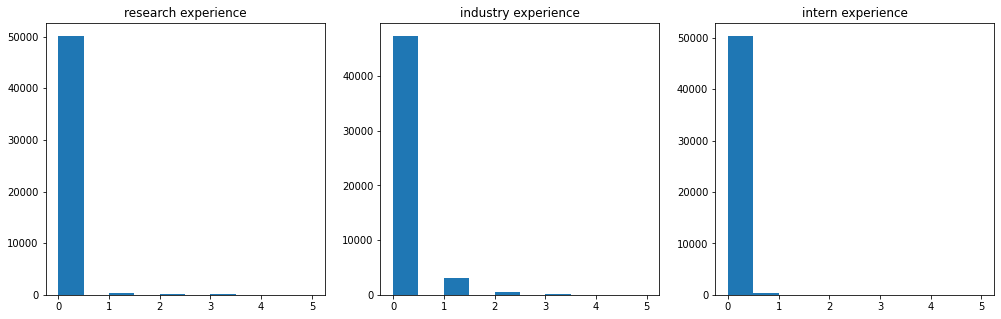

In [8]:
#to plot the histograms of all types of experiences
fig,ax=plt.subplots(1,3, figsize=(17,5))
ax[0].hist(df.researchExp)
ax[0].set_title("research experience")
ax[1].hist(df.industryExp)
ax[1].set_title("industry experience")
ax[2].hist(df.internExp)
ax[2].set_title("intern experience")
plt.show()

In [9]:
#to check if any of the columns are related if so what is the functional form
fig = px.scatter_matrix(df,dimensions=['confPubs',"journalPubs","internExp","industryExp","researchExp","Percentile","greA","greV","greQ"])
fig.show()

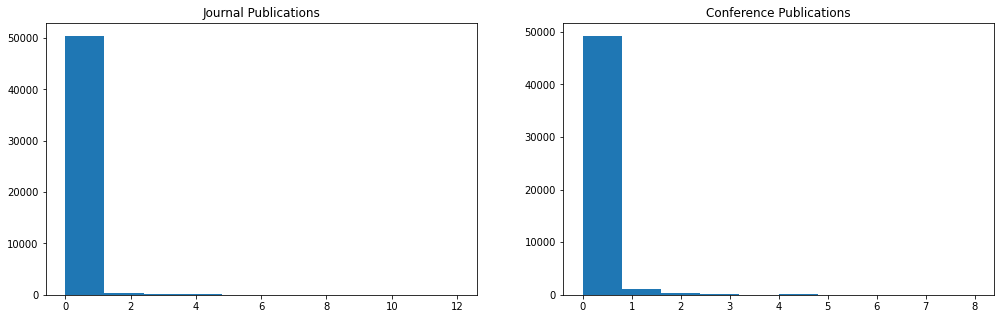

In [10]:
#to plot histograms of all types of publications
fig,ax=plt.subplots(1,2, figsize=(17,5))
ax[0].hist(df.journalPubs)
ax[0].set_title("Journal Publications")
ax[1].hist(df.confPubs)
ax[1].set_title("Conference Publications")
plt.show()

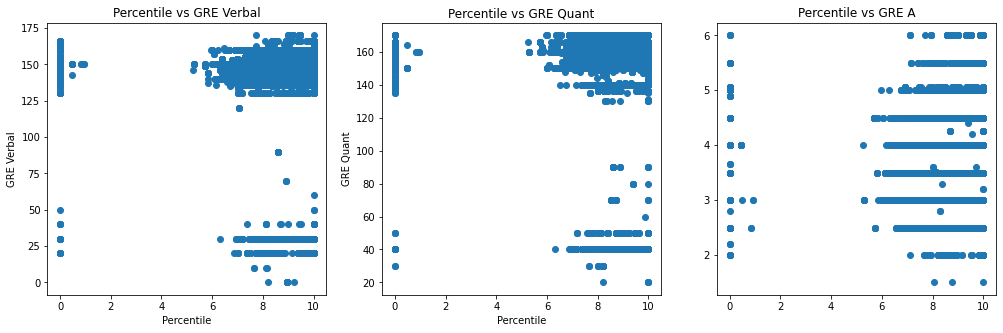

gre scores with percentile
0.054979731067458903
0.041841331669180915
experiences with percentile
0.015370530337709052
-0.0030998208267614302
0.013854099808363753
publications with percentile
0.02070427871224402
0.019598488579762763
publications with experience
0.08502984693098616
0.1537905192763935
0.310476727632058
0.05446363762931368
0.14388464028011913
0.17882204882545163


In [11]:
# to plot scatter plots of Percentile vs different GRE scores
fig,ax=plt.subplots(1,3, figsize=(17,5))
ax[0].scatter(df.Percentile , df.greV)
ax[0].set_title("Percentile vs GRE Verbal")
ax[0].set_xlabel("Percentile")
ax[0].set_ylabel("GRE Verbal")
ax[1].scatter(df.Percentile ,df.greQ)
ax[1].set_title("Percentile vs GRE Quant")
ax[1].set_xlabel("Percentile")
ax[1].set_ylabel("GRE Quant")
ax[2].scatter(df.Percentile, df.greA)
ax[2].set_title("Percentile vs GRE A")
plt.show()

#gre scores with percentile
print("gre scores with percentile")
corr, _ = pearsonr(df.Percentile , df.greQ)
print(corr)
corr, _ = pearsonr(df.Percentile , df.greV)
print(corr)


#experiences with percentile
print("experiences with percentile")
corr, _ = pearsonr(df.researchExp , df.Percentile)
print(corr)
corr, _ = pearsonr(df.industryExp , df.Percentile)
print(corr)
corr, _ = pearsonr(df.internExp , df.Percentile)
print(corr)

#publications with percentile
print("publications with percentile")
corr, _ = pearsonr(df.Percentile , df.confPubs)
print(corr)
corr, _ = pearsonr(df.Percentile , df.journalPubs)
print(corr)

#publications with experience
print("publications with experience")
corr, _ = pearsonr(df.industryExp , df.confPubs)
print(corr)
corr, _ = pearsonr(df.internExp , df.confPubs)
print(corr)
corr, _ = pearsonr(df.researchExp , df.confPubs) #positive correlation
print(corr)
corr, _ = pearsonr(df.industryExp , df.journalPubs)
print(corr)
corr, _ = pearsonr(df.internExp , df.journalPubs)
print(corr)
corr, _ = pearsonr(df.researchExp , df.journalPubs) #positive correlation
print(corr)




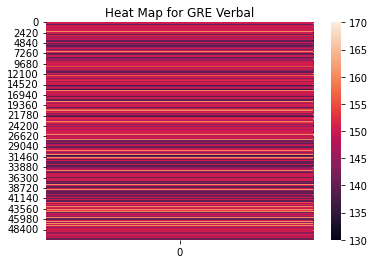

In [12]:
# Heat maps of GRE scores
sns.heatmap(np.asarray(df["greV"]).reshape(50803,1),vmin=130,vmax=170)
plt.title("Heat Map for GRE Verbal")
plt.show()

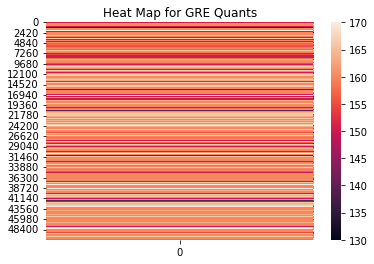

In [13]:
sns.heatmap(np.asarray(df["greQ"]).reshape(50803,1),vmin=130,vmax=170)
plt.title("Heat Map for GRE Quants")
plt.show()

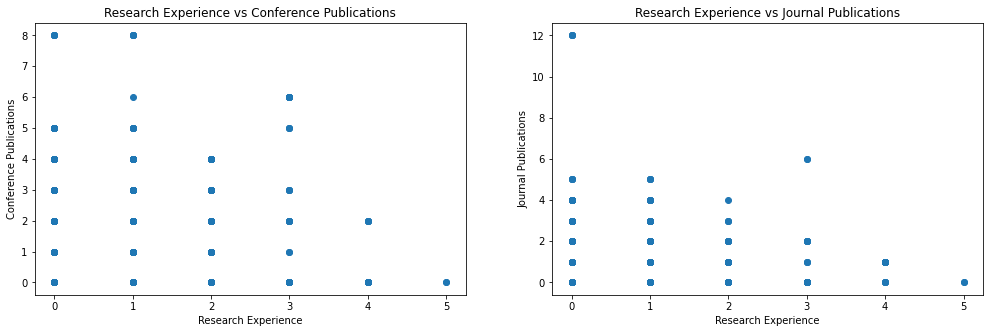

In [14]:
#Scatter plots of Research Experience vs different publications
fig,ax=plt.subplots(1,2, figsize=(17,5))
ax[0].scatter(df.researchExp,df.confPubs)
ax[0].set_title("Research Experience vs Conference Publications")
ax[0].set_xlabel("Research Experience")
ax[0].set_ylabel("Conference Publications")
ax[1].scatter(df.researchExp ,df.journalPubs)
ax[1].set_title("Research Experience vs Journal Publications")
ax[1].set_xlabel("Research Experience")
ax[1].set_ylabel("Journal Publications")
plt.show()

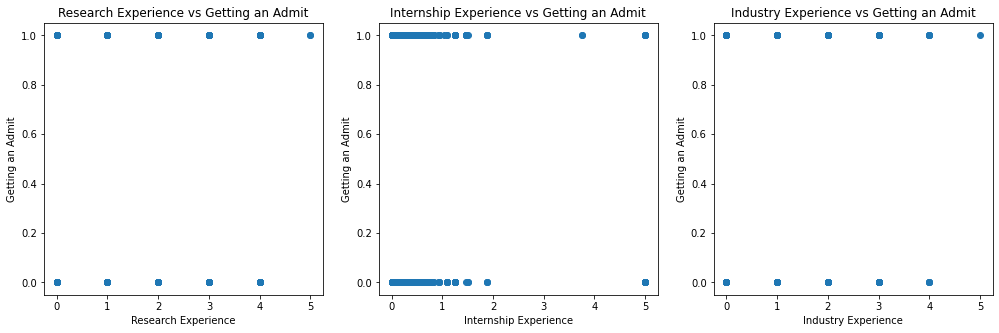

-0.014506469631868305
-0.027229269412530767
-0.031857643833425


In [15]:
#Scatter plots of different experiences vs Getting an Admit
fig,ax=plt.subplots(1,3, figsize=(17,5))
ax[0].scatter(df.researchExp , df.admit)
ax[0].set_title("Research Experience vs Getting an Admit")
ax[0].set_xlabel("Research Experience")
ax[0].set_ylabel("Getting an Admit")
ax[1].scatter(df.internExp,df.admit)
ax[1].set_title("Internship Experience vs Getting an Admit")
ax[1].set_xlabel("Internship Experience")
ax[1].set_ylabel("Getting an Admit")
ax[2].scatter(df.industryExp,df.admit)
ax[2].set_title("Industry Experience vs Getting an Admit")
ax[2].set_xlabel("Industry Experience")
ax[2].set_ylabel("Getting an Admit")
plt.show()

corr, _ = pearsonr(df.researchExp , df.admit)
print(corr)
corr, _ = pearsonr(df.internExp , df.admit)
print(corr)
corr, _ = pearsonr(df.industryExp , df.admit)
print(corr)

-0.014491380765678154
-0.02320151514479752


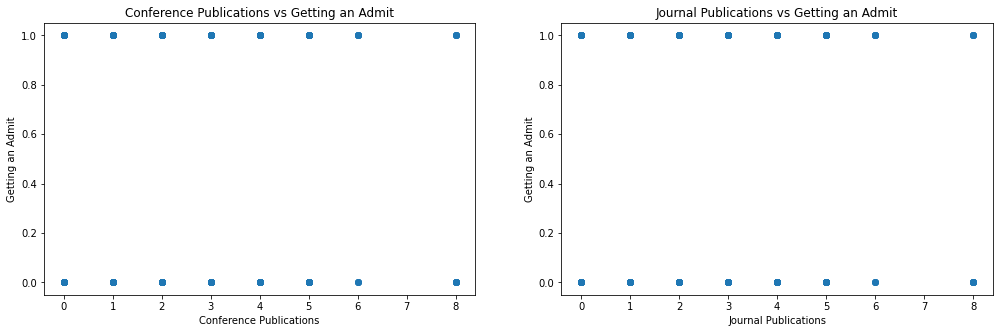

In [16]:
#Scatter plots of different publications vs Getting an Admit
fig,ax=plt.subplots(1,2, figsize=(17,5))
ax[0].scatter(df.confPubs , df.admit)
ax[0].set_title("Conference Publications vs Getting an Admit")
ax[0].set_xlabel("Conference Publications")
ax[0].set_ylabel("Getting an Admit")
ax[1].scatter(df.confPubs , df.admit)
ax[1].set_title("Journal Publications vs Getting an Admit")
ax[1].set_xlabel("Journal Publications")
ax[1].set_ylabel("Getting an Admit")

corr, _ = pearsonr(df.confPubs , df.admit)
print(corr)
corr, _ = pearsonr(df.journalPubs , df.admit)
print(corr)

Model Fitting and some Data transformation

In [17]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics
import numpy as np
from sklearn.linear_model import LinearRegression
from collections import defaultdict
import matplotlib.pyplot as plt

df=df.reset_index()
df2=df.drop(["index","userProfileLink","department","userName","specialization","major","topperCgpa",'termAndYear','cgpa','cgpaScale','ugCollege','program'],axis=1)

#assigning scores to universities using their acceptance rate as the measure 
#higher the acceptance rate lower the score and vice versa
def assignUnivScores(df,listOfUnivs):
    admitCount=dict()
    for univ in listOfUnivs:
        df2=df[df["univName"]==univ]
        applicationCount=len(df2)
        df2=df2[df2["admit"]==1]
        admitCount[univ]=len(df2)/applicationCount
    return admitCount

listOfUnivs=list(set(df["univName"]))
admitCount=assignUnivScores(df,listOfUnivs)
admitCount=sorted(admitCount.items(),key=lambda key_value_pair:(key_value_pair[1],key_value_pair[0]))
univRanking=dict()

for (univ,rating) in admitCount:
    if 0 <= rating <=0.1:
        univRanking[univ]=10
    if 0.1<rating<=0.2:
        univRanking[univ]=9
    if 0.2<rating<=0.3:
        univRanking[univ]=8
    if 0.3<rating<=0.4:
        univRanking[univ]=7
    if 0.4<rating<=0.5:
        univRanking[univ]=6
    if 0.5<rating<=0.6:
        univRanking[univ]=5
    if 0.6<rating<=0.7:
        univRanking[univ]=4
    if 0.7<rating<=0.8:
        univRanking[univ]=3
    if 0.8<rating<=1:
        univRanking[univ]=2

In [70]:
df2["toeflEssay"].fillna(df2["toeflEssay"].astype(float).mean(),inplace=True)
df2["greA"].fillna(df2["greA"].astype(float).mean(),inplace=True)
x_data=df2[df2["admit"]==1]
x_data=df2.iloc[:,df2.columns!="admit"]
temp=x_data
x_data=x_data.iloc[:,x_data.columns!="univName"]
y_data=[]

for i in range(len(x_data)):
    y_data.append(univRanking[temp.iloc[i,10]])

In [87]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.2,random_state=1024)
LR=LinearRegression(normalize=True)
LR.fit(x_train,y_train)
prediction=LR.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)





In [72]:
#Predict the universities that the student has a shot of getting admitted to
def predictUniv(prediction):
  pred=[]
  for i in range(len(prediction)):
      univs=[]
      for key,value in univRanking.items():
          if value<=round(prediction[i]):
              univs.append(key)
      pred.append(univs)
  return pred

In [73]:
#accuracy function for the model
def accuracy(prediction):
    count=0
    indices=list(x_test.index)
    for i in range(len(indices)):
        d=df2.iloc[indices[i],:]
        isAdmit=int(d.admit)
        isPresent=int(d.univName in prediction[i])
        if isAdmit ^ isPresent==0:
            count+=1
    return (count/len(indices))

In [88]:
#Calculating Accuracy of our model
accuracy(predictUniv(prediction))

0.656923531148509

In [82]:
#checking out the recommendation using a randomly generated student data
data=pd.DataFrame([[0,0,102,23,1,140,165,0,4,0,9]],columns=['researchExp', 'industryExp', 'toeflScore', 'toeflEssay', 'internExp','greV', 'greQ', 'journalPubs', 'greA', 'confPubs','Percentile'])
prediction=LR.predict(data)

In [84]:
#We find all the safe universities
univ_list=predictUniv(prediction)

In [85]:
#We are recommending maximum of 5 universities which includes 4 safe universities and 1 ambitious university
acceptanceRate=dict()
for (univ,rating) in admitCount:
  acceptanceRate[univ]=rating

def getRecommendations(safe_univ_list,acceptanceRate):
    allUsersRecommendations=[]

    for univs in safe_univ_list:
      temp=[]
      for safe_univ in univs:
          temp.append((acceptanceRate[safe_univ],safe_univ))
      temp.sort()
      temp=list(map(lambda x:x[1],temp))
      if len(temp)<4:
          allUsersRecommendations.append(temp)
          continue
      finalSafeRecommendations=[temp[0],temp[1],temp[2],temp[3]]
      scoreOfCurrentHighest=univRanking[finalSafeRecommendations[-1]]
      ambitious=[]

      for univ,ranking in univRanking.items():
          if ranking==scoreOfCurrentHighest+1:
            ambitious.append(univ)
            break
      finalRecommendations=finalSafeRecommendations + ambitious
      allUsersRecommendations.append(finalRecommendations)

    return allUsersRecommendations
    
getRecommendations(univ_list,acceptanceRate)


[['University of Michigan Ann Arbor',
  'Cornell University',
  'SUNY Stony Brook',
  'Ohio State University Columbus',
  'Virginia Polytechnic Institute and State University']]